# CDK2: evaluations using k conformations
## Data load and preprocessing

In [16]:
%run ./1_Helper_functions.ipynb

In [2]:
%load_ext rpy2.ipython

In [3]:
protein_name='cdk2'
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

R_a = round(y.sum() / len(y), 2)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(3466, 402)
415
Ra = 0.12


## Estimators
### ML Classifiers

In [4]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified", "random_state": 42}
dclf = DummyClassifier(**hyparams)

In [5]:
from sklearn.neighbors import KNeighborsClassifier

hyparams ={'n_neighbors': 1, 'n_jobs': 4}
knn = KNeighborsClassifier(**hyparams)

In [6]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [7]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

In [8]:
# ML Classifier
ml_classifiers = {
    'knn': knn,
    'lr': lr,
    'xgb': xgb,
    'dclf': dclf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [9]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
    'VOTE': get_vote_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [10]:
estimators = {**ml_classifiers, **cs_functions}

### Evaluation metrics 

In [11]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_02 = {'metric_name': 'ef', 
                    'fraction': 0.02, 'method':'normalized'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': 0.12, 'method':'normalized'},
             pROC = {'metric_name': 'p_roc'},
             pr_auc = {'metric_name': 'pr_auc'}
            )

# Hold-out Validation

In [12]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def n_hold_out_validation_SAVE(filename, **kwargs):
    return n_hold_out_validation(**kwargs)


## k-random conformations

### 30 replicas


In [13]:
max_confs = 402
k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256, max_confs]
random_state=42

full_results = {}

## Random Selection

In [18]:
%%time

# ************
test_name = 'random'
full_results[test_name] = {}
# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    
    results = n_hold_out_validation_RANDOM_CONFS_SAVE(
                                            filename, n_reps, k, max_confs, 
                                            X, y, metrics, random_state)
        
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = results


File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-256
Evaluation with k=256 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-402
Evaluation with k=402 fi

In [19]:
df_random = get_group_stats(full_results[test_name], metric_name='roc_auc', indexes_values=k_values)

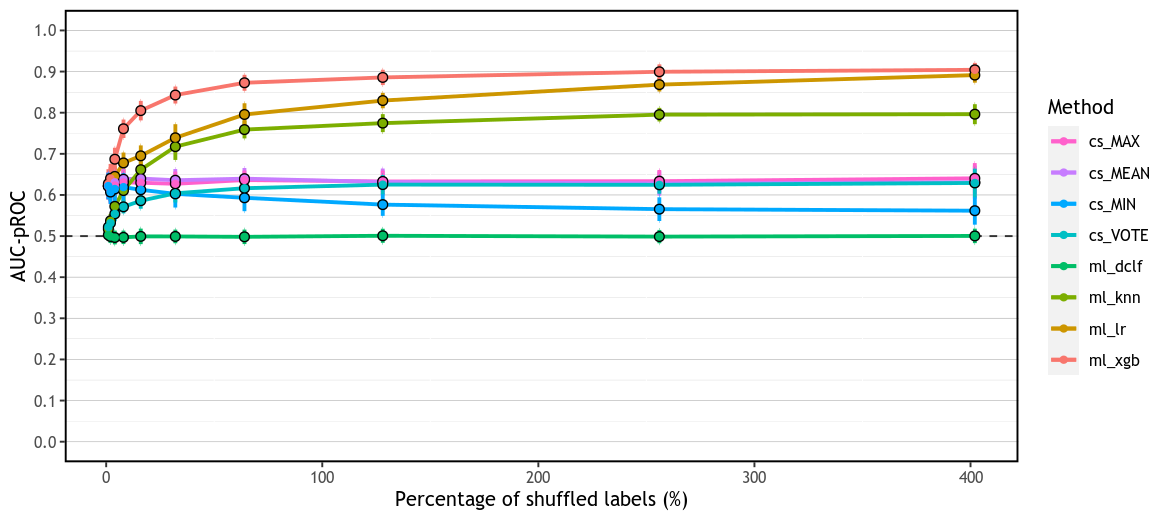

In [22]:
%%R -i df_random  -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(8)

plot_lines(df_random, cbbPalette, y_min=0.0, y_max=1., 
               y_label='AUC-pROC', base_h_line=0.5, switch_x=FALSE) 

## REF preselected => XGB

In [44]:
# Open RFE_estimator
dataset = 'MERGED'
model_name = 'XGB_tree'
split = 'random'
filename = f'../6_Machine_Learning_Models/ml_models/RFECV_selector_{model_name}_{dataset}_{split}_split.joblib'
# RFE selector LogReg Random split
rfe_selector = joblib.load(filename)
rfe_selector.ranking_
df_ranks = pd.DataFrame({'pdb_id': X_merged_dksc.columns, 'rfe_ranking': rfe_selector.ranking_})
df_ranks = df_ranks.sort_values('rfe_ranking')

Int64Index([0, 182], dtype='int64')

In [45]:
%%time

# ************
test_name = 'RFExgb'
full_results[test_name] = {}
# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = n_hold_out_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_reps=n_reps, random_state=random_state
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File saved: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-1
Evaluation with k=1 finished.
File saved: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-2
Evaluation with k=2 finished.
File saved: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-4
Evaluation with k=4 finished.
File saved: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-8
Evaluation with k=8 finished.
File saved: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-16
Evaluation with k=16 finished.
File saved: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-32
Evaluation with k=32 finished.
File saved: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-64
Evaluation with k=64 finished.
File saved: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-128
Evaluation with k=128 finished.
File saved: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-256
Evaluation with k=256 finished.
File saved: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-402
Evaluation with k=402 finished.
CP

In [46]:
df_RFExgb = get_group_stats(full_results[test_name], metric_name='roc_auc', indexes_values=k_values)

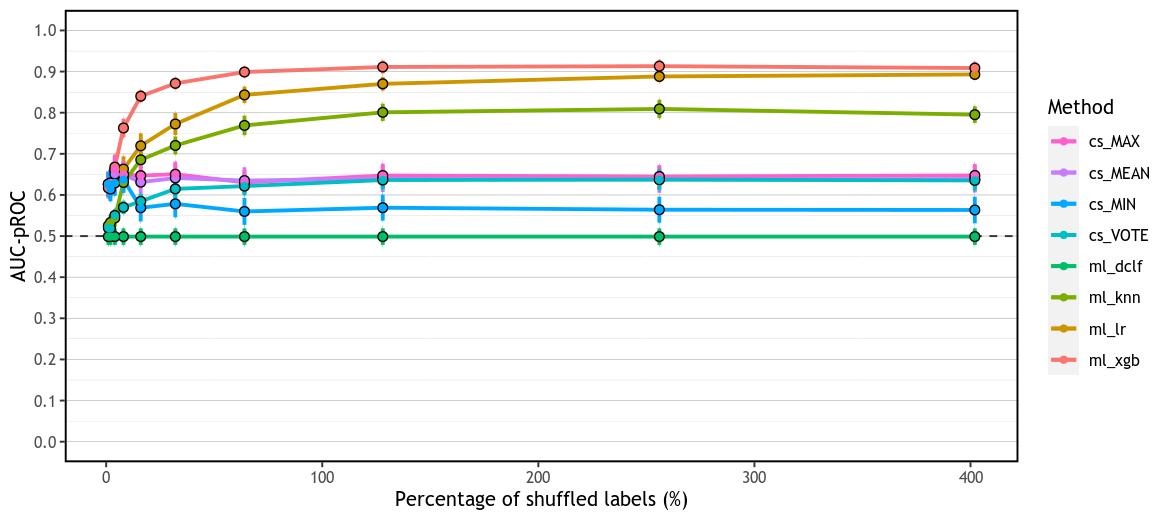

In [48]:
%%R -i df_RFExgb  -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(8)

plot_lines(df_RFExgb, cbbPalette, y_min=0.0, y_max=1., 
               y_label='AUC-pROC', base_h_line=0.5, switch_x=FALSE) 

In [164]:
%%time
evaluation_name='ho30'
ho30 = n_hold_out_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X, y=y, metrics=metrics, 
                      n_reps=30, random_state=42)

full_names = ['1-NN', 'Log. Reg.', 'XGB', 'DummyClf', 'csMAX', 'csMEAN', 'csMIN', 'csVOTE']
new_names = dict(zip(
    [*ho30.columns],
    full_names))

ho30 = ho30.rename(columns=new_names)

File loaded: ./cachedir/ho30_cdk2
CPU times: user 3.98 ms, sys: 0 ns, total: 3.98 ms
Wall time: 3.56 ms


In [165]:
%run Friedman_and_Nemenyi_test.ipynb
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## AUC-ROC

In [166]:
# ROC-AUC
metric_name='roc_auc'

# Normality
display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))

display(friedmanTest(ho30.loc[metric_name]))

df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.25, random_state=42)

,1-NN,Log. Reg.,XGB,DummyClf,csMAX,csMEAN,csMIN,csVOTE
Normality,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,39.636122,0.000001


,chi^2,dof,p_value
Friedman Test,200.211111,7,1.035502e-39


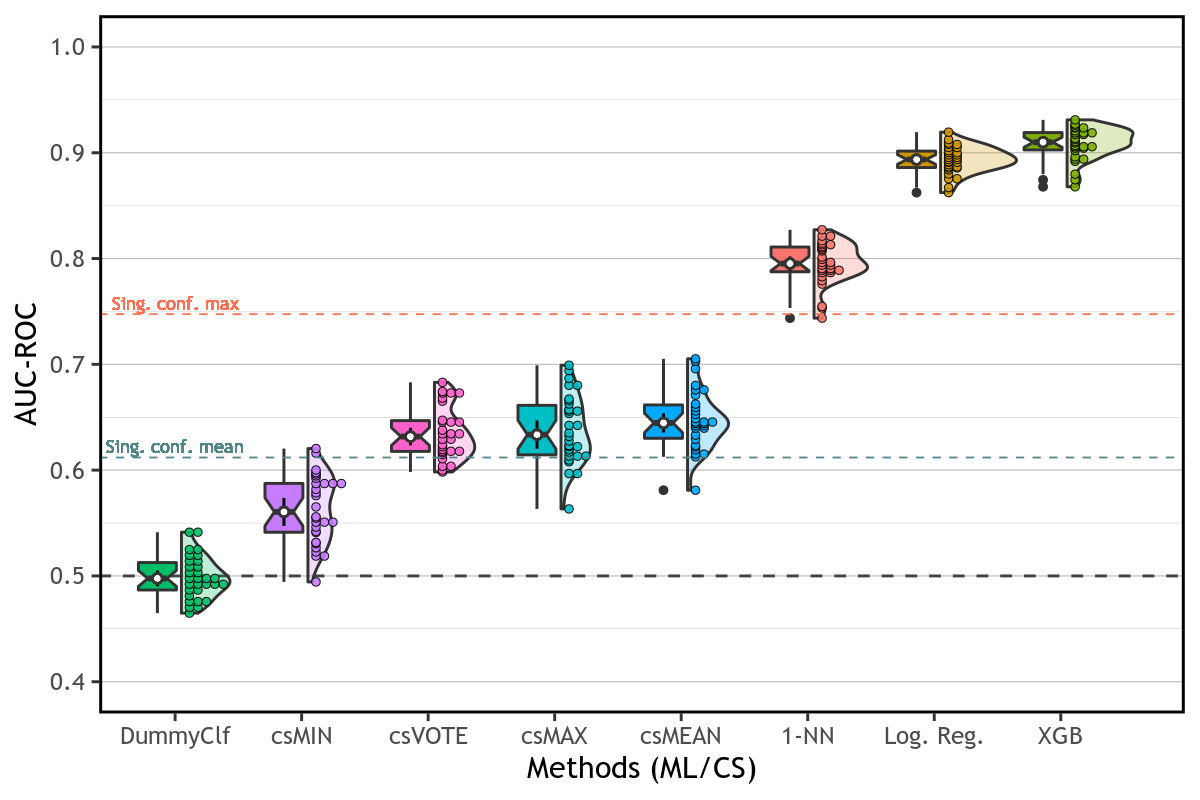

In [167]:
%%R -i full_names -i df_R -i single_mean -i single_max  -w 6 -h 4 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.4, y_max=1.) +
add_ref_values('Sing. conf. mean', single_mean, color='cadetblue4') + 
add_ref_values('Sing. conf. max', single_max, color='coral1')

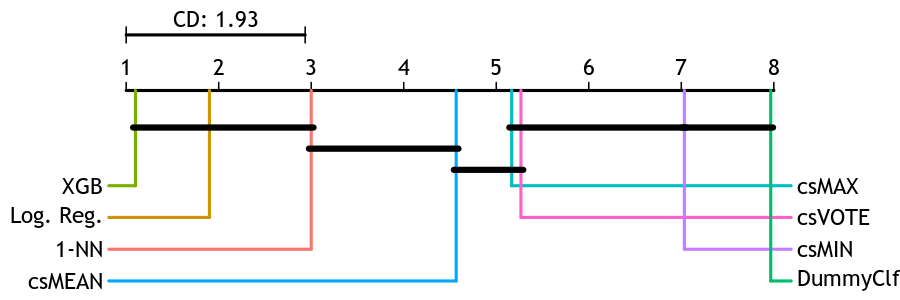

In [168]:
%%R -i df_R -i full_names -w 6 -h 2 --units in -r 150
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

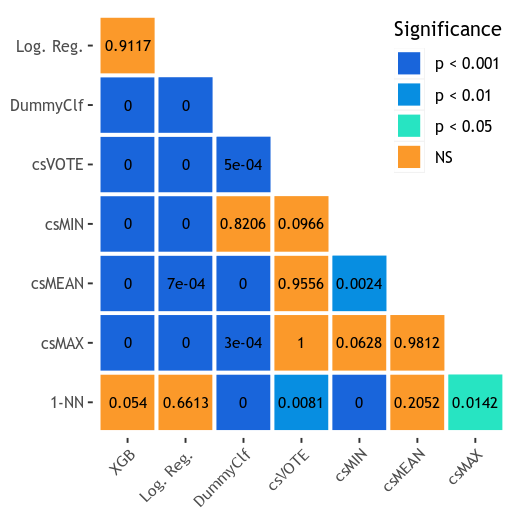

In [169]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

## pAUC-ROC Normalized

In [170]:
# Random value given n_a and N
test_size=0.25
N = y.size*0.25
n_a = y.sum()*0.25
print(N, n_a)
pROC_base_random = pROC_auc_rand(N, n_a, normalized=True)
print('Max pACU-ROC (non-normalized):', 1/N)
pROC_base_random

866.5 103.75
Max pACU-ROC (non-normalized): 0.001154068090017311


0.14766080669711348

In [171]:
# ROC-AUC
metric_name='pROC'

# Normality
display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))
# Friedman test
display(friedmanTest(ho30.loc[metric_name]))

df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.25, random_state=42)

,1-NN,Log. Reg.,XGB,DummyClf,csMAX,csMEAN,csMIN,csVOTE
Normality,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,23.510401,0.001388


,chi^2,dof,p_value
Friedman Test,206.288889,7,5.339816e-41


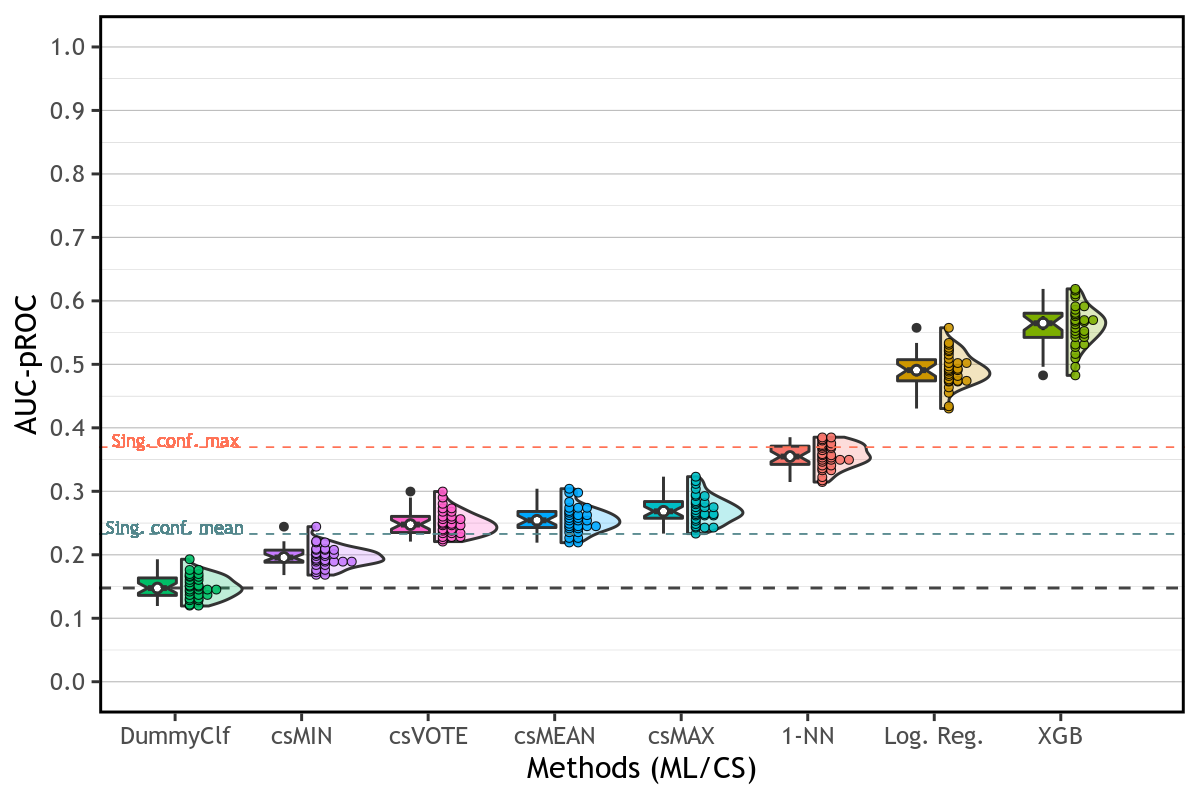

In [173]:
%%R -i full_names -i df_R -i single_mean -i single_max -ipROC_base_random -w 6 -h 4 --units in -r 200
source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.0, y_max=1., 
               dot_size=7, bin_width=0.002,
               y_label='AUC-pROC', base_h_line=pROC_base_random) +
add_ref_values('Sing. conf. mean', single_mean, color='cadetblue4') + 
add_ref_values('Sing. conf. max', single_max, color='coral1')

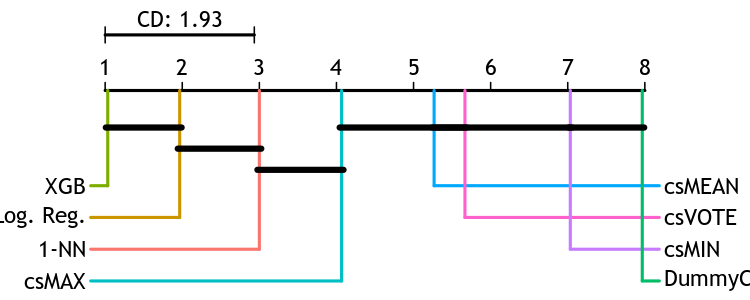

In [174]:
%%R -i df_R -i full_names -w 5 -h 2 --units in -r 150
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

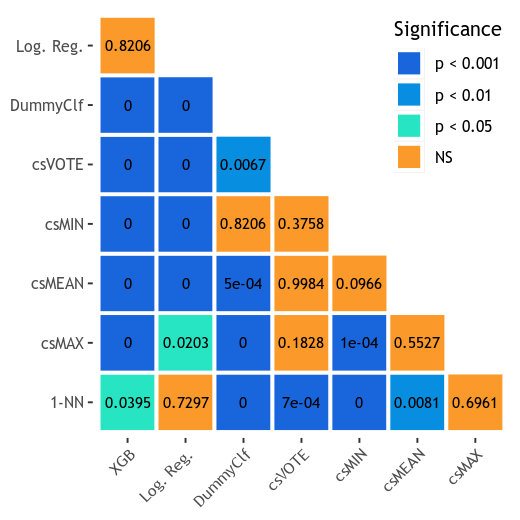

In [175]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

## EF 2%


In [176]:
# ROC-AUC
metric_name='nef_02'

# Normality
display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))
# Friedman test
display(friedmanTest(ho30.loc[metric_name]))

df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.25, random_state=42)

,1-NN,Log. Reg.,XGB,DummyClf,csMAX,csMEAN,csMIN,csVOTE
Normality,1,0,0,0,1,1,1,0


,statistic,p
Bartlett,29.223941,0.000132


,chi^2,dof,p_value
Friedman Test,178.763889,7,3.553389e-35


R[write to console]: notch went outside hinges. Try setting notch=FALSE.

R[write to console]: notch went outside hinges. Try setting notch=FALSE.

R[write to console]: notch went outside hinges. Try setting notch=FALSE.

R[write to console]: notch went outside hinges. Try setting notch=FALSE.



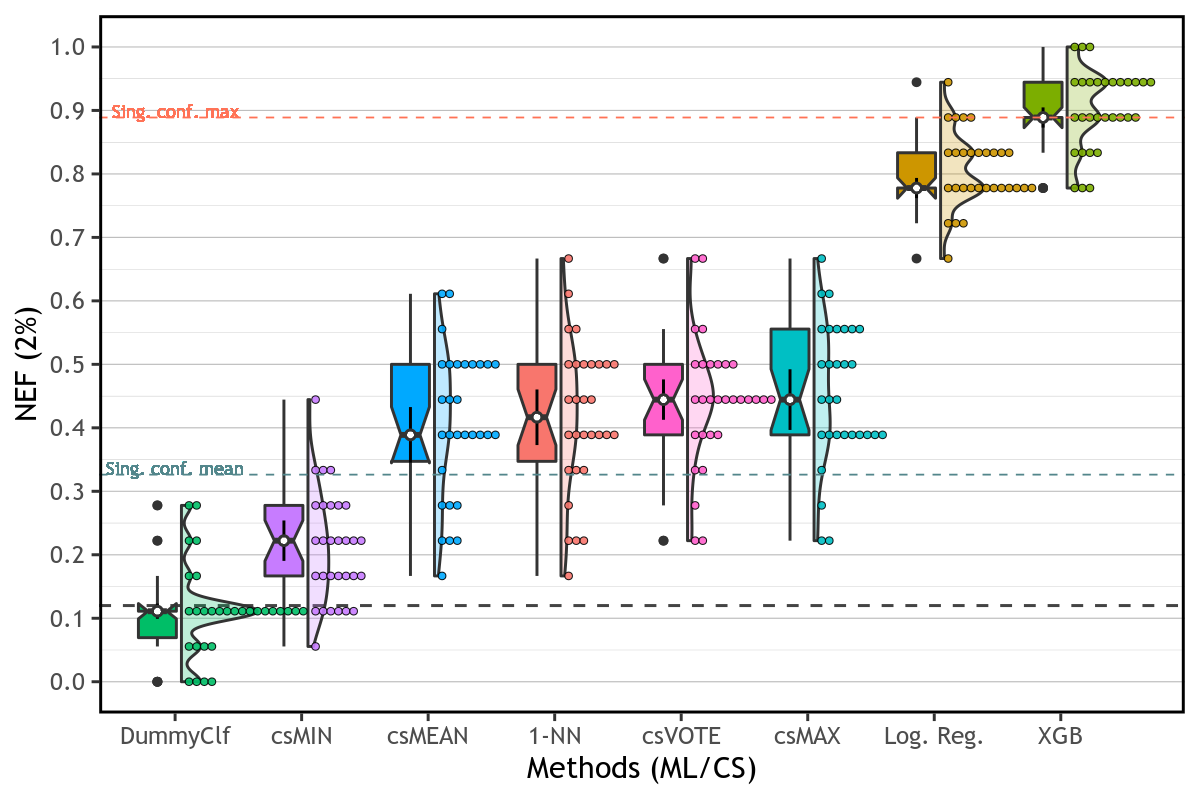

In [178]:
%%R -i df_Rmelted -i df_R -i full_names -i R_a -i single_mean -i single_max -w 6 -h 4 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.0, y_max=1.0, 
               y_label='NEF (2%)', dot_size=12, bin_width=0.001, base_h_line=R_a) +
add_ref_values('Sing. conf. mean', single_mean, color='cadetblue4') + 
add_ref_values('Sing. conf. max', single_max, color='coral1')

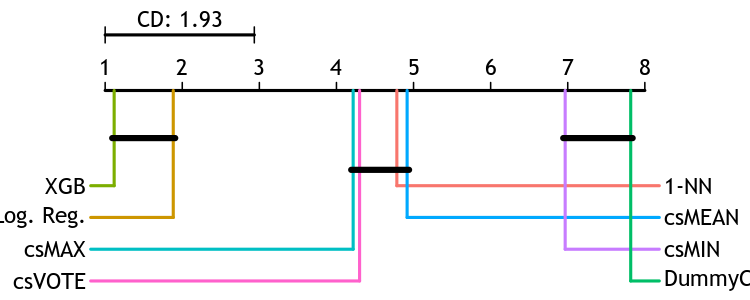

In [179]:
%%R -i df_R -i full_names -w 5 -h 2 --units in -r 150
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

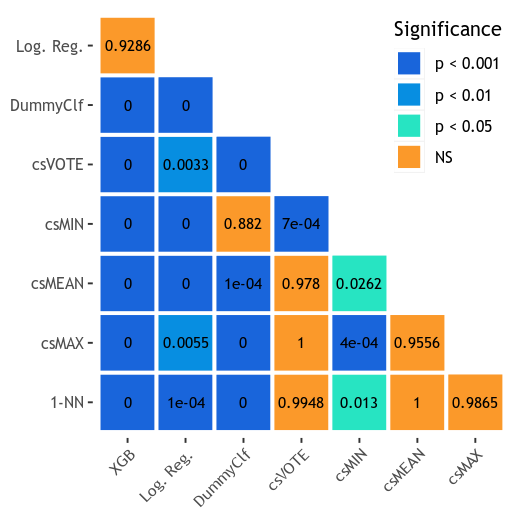

In [180]:
%%R -i df_R  -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

## EF 12% = Ra

In [181]:
# ROC-AUC
metric_name='nef_12_Ra'

# Normality
display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))
# Friedman test
display(friedmanTest(ho30.loc[metric_name]))

df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.25, random_state=42)

,1-NN,Log. Reg.,XGB,DummyClf,csMAX,csMEAN,csMIN,csVOTE
Normality,0,1,1,1,1,1,1,1


,statistic,p
Bartlett,4.015617,0.777977


,chi^2,dof,p_value
Friedman Test,203.766667,7,1.828075e-40


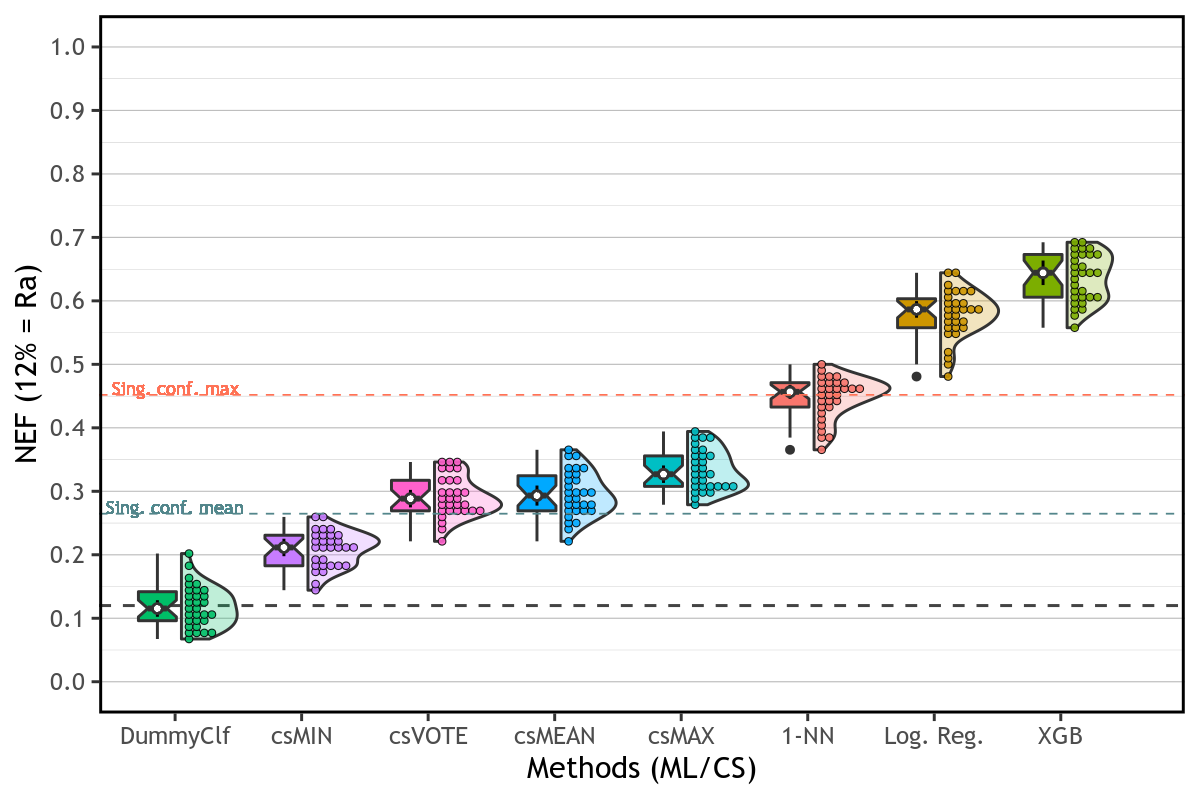

In [183]:
%%R -i df_Rmelted -i df_R -i full_names -i R_a -i single_mean -i single_max -w 6 -h 4 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.0, y_max=1.0, 
               y_label='NEF (12% = Ra)', dot_size=12, bin_width=0.001, base_h_line=R_a) +
add_ref_values('Sing. conf. mean', single_mean, color='cadetblue4') + 
add_ref_values('Sing. conf. max', single_max, color='coral1')

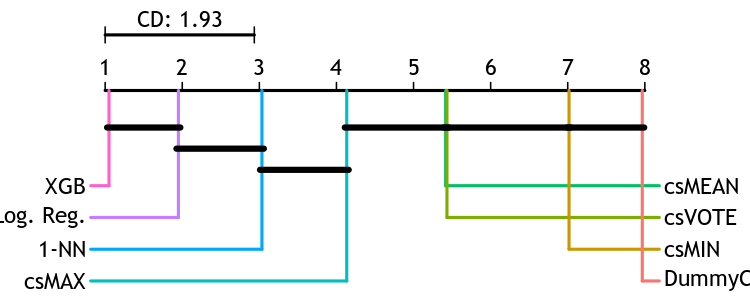

In [184]:
%%R -i df_R  -w 5 -h 2 --units in -r 150
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

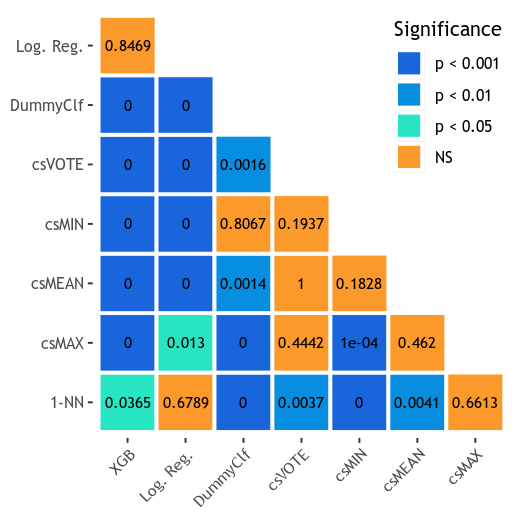

In [185]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

# Y-randomization test

In [186]:
@run_or_load_joblib
def n_hout_val_scrambling(filename, y, random_chi,  **kwargs):
    y_rand = randomize_y_labels(y_target=y, random_chi=random_chi)
    results = n_hold_out_validation(y=y_rand, **kwargs)
    return results

In [187]:
%%time
chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
n_reps=30
chi_results = {}
evaluation_name = f'y_scrambling_{n_reps}_reps'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = n_hout_val_scrambling(filename=filename, 
                             random_chi=chi, estimators=estimators, 
                             X=X, y=y, metrics=metrics, 
                             n_reps=n_reps, random_state=42)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result
    

File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-1
Fraction chi=1 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.75
Fraction chi=0.75 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.5
Fraction chi=0.5 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.25
Fraction chi=0.25 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.0
Fraction chi=0.0 finished.
CPU times: user 18.6 ms, sys: 11 µs, total: 18.6 ms
Wall time: 17.7 ms


## AUC-ROC

In [188]:
df_y_random = get_group_stats(chi_results, metric_name='roc_auc')
df_y_random = df_y_random.replace(new_names)

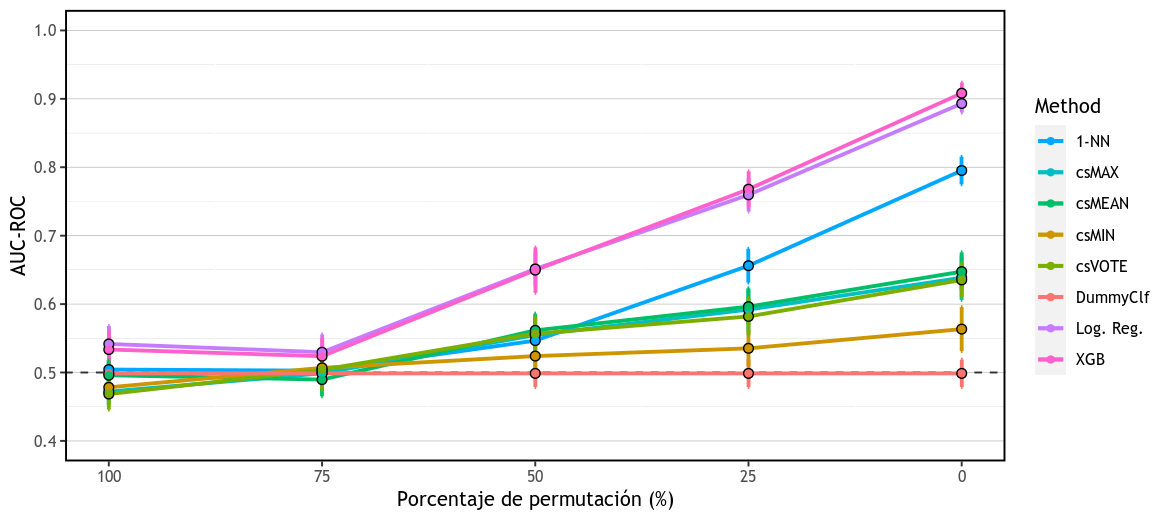

In [189]:
%%R -i df_y_random -i df_R -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_lines(df_y_random, cbbPalette, x_label='Porcentaje de permutación (%)')

## AUC-pROC Normalized

In [190]:
df_y_random = get_group_stats(chi_results, metric_name='pROC')
df_y_random = df_y_random.replace(new_names)

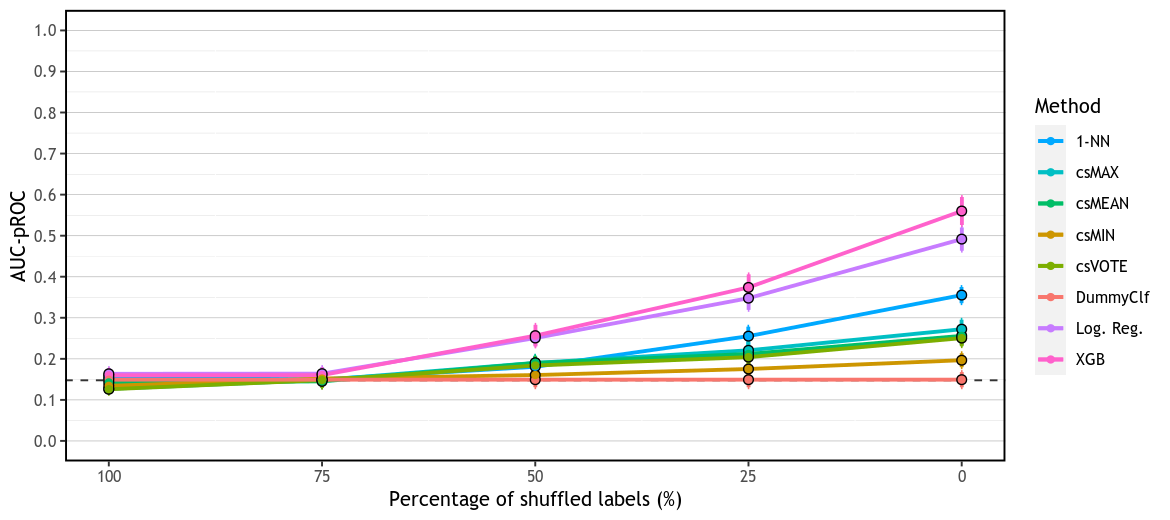

In [191]:
%%R -i df_y_random -i df_R -i pROC_base_random -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_lines(df_y_random, cbbPalette, y_min=0.0, y_max=1., 
               y_label='AUC-pROC', base_h_line=pROC_base_random)

## EF 2% 

In [192]:
df_y_random = get_group_stats(chi_results, metric_name='nef_02')
df_y_random = df_y_random.replace(new_names)

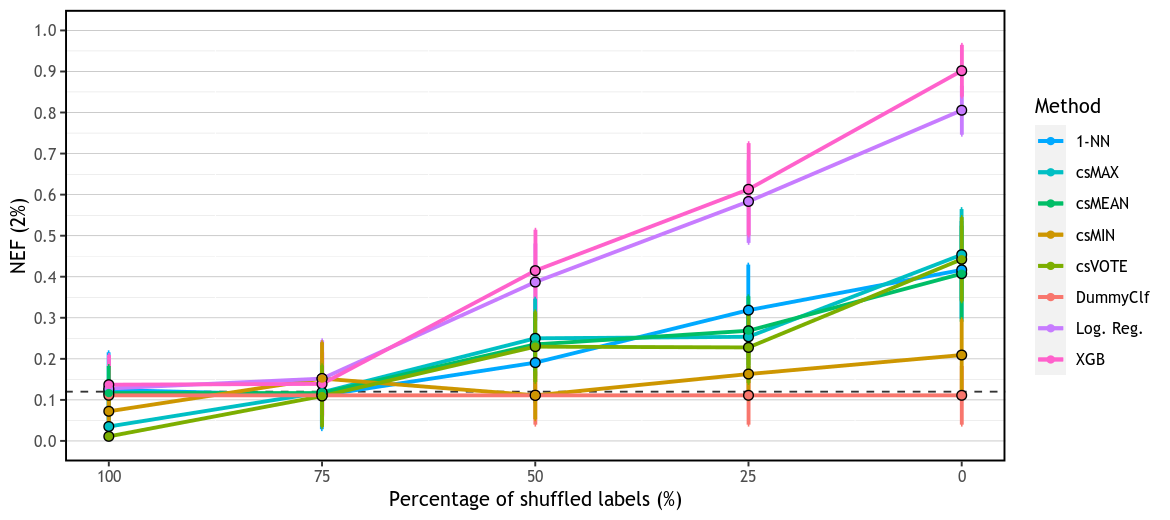

In [193]:
%%R -i df_y_random -i df_R -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_lines(df_y_random, cbbPalette, y_min=0, base_h_line=0.12, y_label='NEF (2%)')

## EF 12% 

In [194]:
df_y_random = get_group_stats(chi_results, metric_name='nef_12_Ra')
df_y_random = df_y_random.replace(new_names)

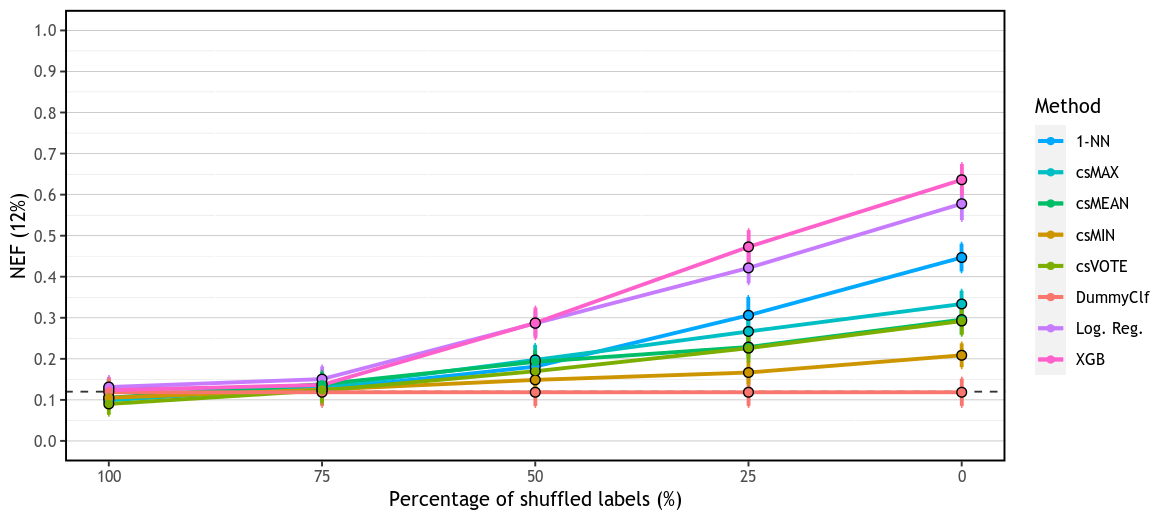

In [195]:
%%R -i df_y_random -i df_R -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_lines(df_y_random, cbbPalette, y_min=0, y_max=1, base_h_line=0.12, y_label='NEF (12%)')